#Introducion

This Notebook is used to practice about computer vision.

The dataset that used in this digit recognizer is from MNIST ("Modified National Institute of Standards and Technology") is the de facto “hello world” dataset of computer vision.

In this competition, my goal is to correctly identify digits from a dataset of tens of thousands of handwritten images.

Practice Skills:
1. Computer vision fundamentals including simple neural networks.
2. Classification methods such as SVM and K-nearest neighbors

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, CSVLogger

In [ ]:
TRAINING_LOGS_FILE = "training_logs.csv"
MODEL_SUMMARY_FILE = "model_summary.txt"
MODEL_FILE = "model.h5"
TRAINING_PLOT_FILE = "training.png"
VALIDATION_PLOT_FILE = "validation.png"
KAGGLE_SUBMISSION_FILE = "kaggle_submission.csv"

GOOGLE_COLAB = True

if GOOGLE_COLAB:
    !pip install livelossplot

from livelossplot import PlotLossesKeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
VERBOSITY = 1
EPOCHS = 100
BATCH_SIZE = 512
CLASSES = 10
CHANNELS = 1
IMAGE_SIZE = 28
IMAGE_WIDTH, IMAGE_HEIGHT = IMAGE_SIZE, IMAGE_SIZE
VALIDATION_RATIO = 0.1

#Download Dataset From Kaggle

In [ ]:
!pip install -q kaggle

In [ ]:
 from google.colab import files 
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"gragihproject","key":"4766f14436144ae1d579e54a1f9ba3bd"}'}

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

!cp -r /content/gdrive/MyDrive/kaggle.json /content

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets list

ref                                                       title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
arnabchaki/data-science-salaries-2023                     Data Science Salaries 2023 💸                         25KB  2023-04-13 09:55:16          21124        582  1.0              
fatihb/coffee-quality-data-cqi                            Coffee Quality Data (CQI May-2023)                   22KB  2023-05-12 13:06:39           2085         51  1.0              
darshanprabhu09/stock-prices-for                          Stock prices of Amazon , Microsoft , Google, Apple   85KB  2023-05-16 15:17:16            928         27  1.0              
ashpalsingh1525/imdb-movies-dataset                       IMDB movies dataset             

In [ ]:
!kaggle competitions download -c digit-recognizer

digit-recognizer.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!mkdir digit-recognizer
!unzip digit-recognizer.zip -d digit-recognizer

mkdir: cannot create directory ‘digit-recognizer’: File exists
Archive:  digit-recognizer.zip
replace digit-recognizer/sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: digit-recognizer/sample_submission.csv  
replace digit-recognizer/test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: digit-recognizer/test.csv  
  inflating: digit-recognizer/train.csv  


#Prepare Dataset from Kaggle

In [ ]:
# Load the data (https://www.kaggle.com/c/digit-recognizer/data)
path = "/content/digit-recognizer"
if GOOGLE_COLAB:
    from google.colab import drive, files
    # drive.mount('/content/drive/')
    path = "/content/digit-recognizer/"
train = pd.read_csv(path + "/train.csv")
test = pd.read_csv(path + "/test.csv")

y = train["label"]
x = train.drop(labels = ["label"], axis = 1) 

In [ ]:
# Reshape data
x = x.values.reshape(-1, IMAGE_WIDTH, IMAGE_HEIGHT, CHANNELS)
test = test.values.reshape(-1, IMAGE_WIDTH, IMAGE_HEIGHT, CHANNELS)

# One-Hot encoding
y = to_categorical(y, num_classes=CLASSES)

# Prepare training/validation sets
x_training, x_validation, y_training, y_validation = train_test_split(x,
                                                                      y,
                                                                      test_size=VALIDATION_RATIO,
                                                                      shuffle = True)

In [ ]:
print('x_training:', x_training.shape)
print('y_training:', y_training.shape)
print('x_validation:', x_validation.shape)
print('y_validation:', y_validation.shape)

x_training: (37800, 28, 28, 1)
y_training: (37800, 10)
x_validation: (4200, 28, 28, 1)
y_validation: (4200, 10)


#ML Model

In [ ]:
# Model (0.995)
model = Sequential()

model.add(Conv2D(filters=32,
                 kernel_size=(5,5),
                 padding='Same', 
                 activation='relu',
                 input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, CHANNELS)))
model.add(Conv2D(filters=32,
                 kernel_size=(5,5),
                 padding='Same', 
                 activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(filters=64, kernel_size=(3,3),padding='Same', 
                 activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3,3),padding='Same', 
                 activation='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(8192, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(2048, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(CLASSES, activation="softmax"))

model.compile(optimizer=RMSprop(lr=0.0001,
                                rho=0.9,
                                epsilon=1e-08,
                                decay=0.00001),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

with open(MODEL_SUMMARY_FILE,"w") as fh:
    model.summary(print_fn=lambda line: fh.write(line + "\n"))

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


#Data Augmentation

In [ ]:
# Data augmentation
data_generator = ImageDataGenerator(rescale=1./255,
                                    rotation_range=1,
                                    zoom_range=0.1, 
                                    width_shift_range=0.05,
                                    height_shift_range=0.05)
data_generator.fit(x_training)

#Model Training

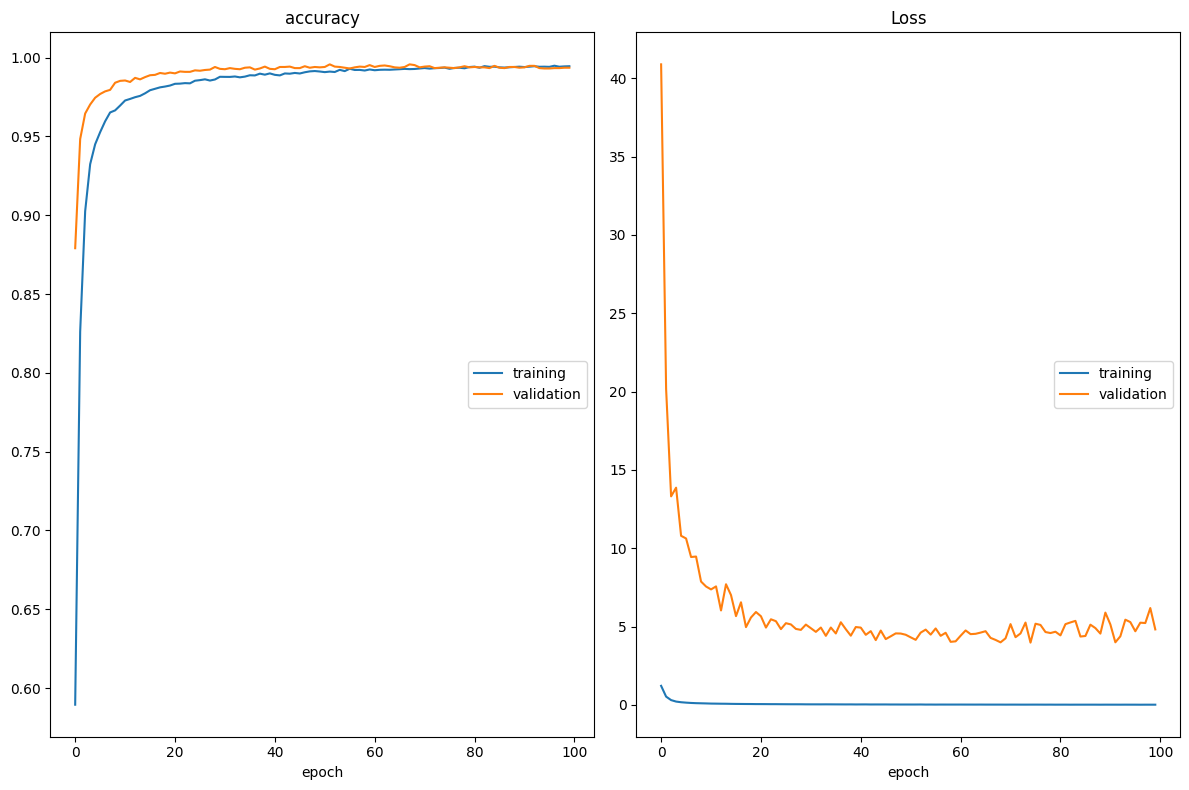

accuracy
	training         	 (min:    0.589, max:    0.995, cur:    0.995)
	validation       	 (min:    0.879, max:    0.996, cur:    0.994)
Loss
	training         	 (min:    0.016, max:    1.221, cur:    0.017)
	validation       	 (min:    3.979, max:   40.892, cur:    4.822)
73/73 [==============================] - 15s 210ms/step - loss: 0.0168 - accuracy: 0.9945 - val_loss: 4.8222 - val_accuracy: 0.9936


In [ ]:
# Training
history = model.fit_generator(data_generator.flow(x_training,
                                                  y_training,
                                                  batch_size=BATCH_SIZE),
                              epochs=EPOCHS,
                              validation_data=(x_validation, y_validation),
                              verbose=VERBOSITY,
                              steps_per_epoch=x_training.shape[0] // BATCH_SIZE,
                              callbacks=[PlotLossesKeras(),
                                         CSVLogger(TRAINING_LOGS_FILE,
                                                   append=False,
                                                   separator=";")])
model.save_weights(MODEL_FILE)

In [ ]:
validation_loss, validation_accuracy = model.evaluate(x_validation, y_validation)
print('Validation loss: ', validation_loss)
print('Validation accuracy: ', validation_accuracy)

132/132 [==============================] - 1s 8ms/step - loss: 4.8222 - accuracy: 0.9936
Validation loss:  4.8221635818481445
Validation accuracy:  0.993571400642395


In [ ]:
predictions = model.predict(test, verbose=2)

875/875 - 3s - 3s/epoch - 3ms/step


#Make CSV file for kaggle submission

In [ ]:
import numpy as np
testY = model.predict(test)
testY = np.argmax(testY, axis = 1)
testY = pd.Series(testY, name="Label")

875/875 [==============================] - 2s 2ms/step


In [ ]:
sub = pd.concat([pd.Series(range(1,28001), name = "ImageID"), testY], axis = 1)
sub.to_csv('submission.csv',index=False)

#Save the model

The model saved in to .h5 and .model format.

.model format used to model prediction in pycharm GUI.

In [ ]:
model.save("digitreg.h5")

In [ ]:
model.save('digitreg.model', save_format='h5')

In [ ]:
model.save('/content/gdrive/MyDrive/Training Result/digitreg.model')

#Model testing and predictions

In [ ]:
# Testing

predictions = model.predict(test)
print(predictions.shape)

875/875 [==============================] - 2s 3ms/step
(28000, 10)


In [ ]:
pd.DataFrame(predictions)

,0,1,2,3,4,5,6,7,8,9
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
27995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
27996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
27997,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
27998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
prediction = np.argmax(predictions, axis=1)
pd.DataFrame(prediction)

,0
0,2
1,0
2,9
3,0
4,3
...,...
27995,9
27996,7
27997,3
27998,9


In [ ]:
print(prediction[0])

2


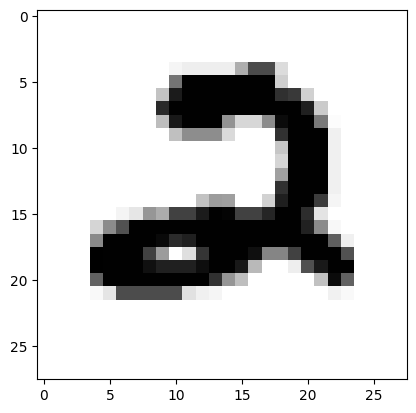

In [ ]:
plt.imshow(test[0].reshape((IMAGE_WIDTH, IMAGE_HEIGHT)), cmap=plt.cm.binary)
plt.show()

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sn

mnist_dataset = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist_dataset.load_data()

<ipython-input-42-75a413e42249>:13: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(num_cells, num_cells, plot_index + 1)


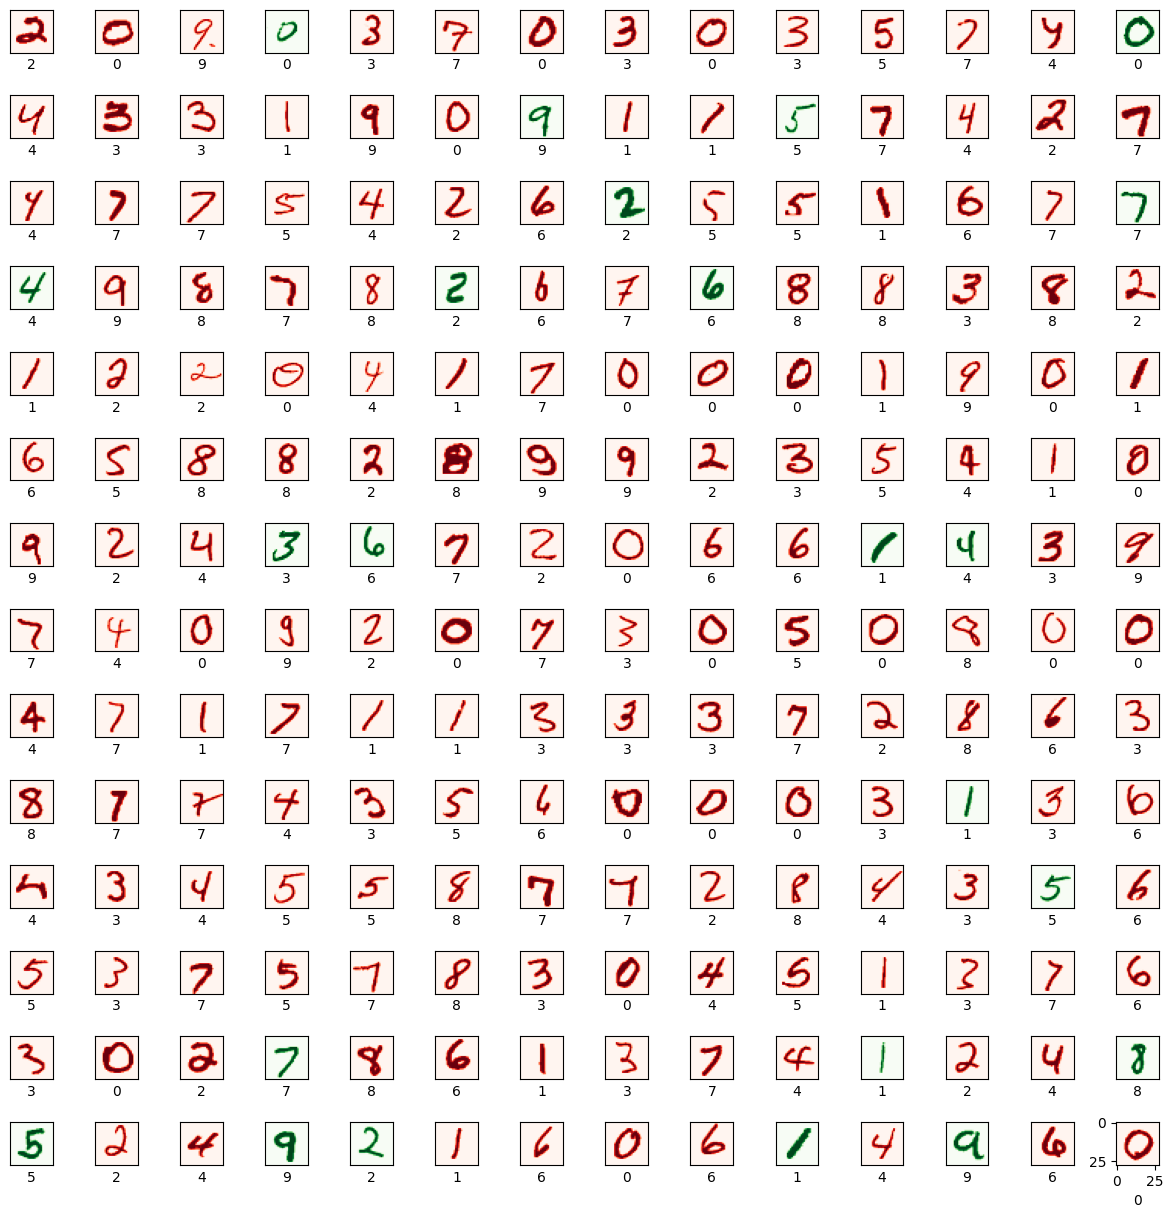

In [ ]:
import math

numbers_to_display = 196
num_cells = math.ceil(math.sqrt(numbers_to_display))
plt.figure(figsize=(15, 15))

for plot_index in range(numbers_to_display):    
    predicted_label = prediction[plot_index]
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    color_map = 'Greens' if predicted_label == y_test[plot_index] else 'Reds'
    plt.subplot(num_cells, num_cells, plot_index + 1)
    # plt.imshow(x_validation[plot_index].reshape((IMAGE_WIDTH, IMAGE_HEIGHT)), cmap=color_map)
    plt.imshow(test[plot_index].reshape((IMAGE_WIDTH, IMAGE_HEIGHT)), cmap=color_map)
    plt.xlabel(predicted_label)

plt.subplots_adjust(hspace=1, wspace=0.5)
plt.show()

In [ ]:
print(predictions.shape)

(28000, 10)


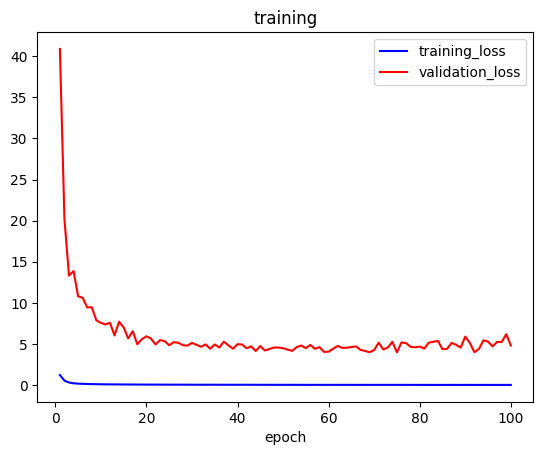

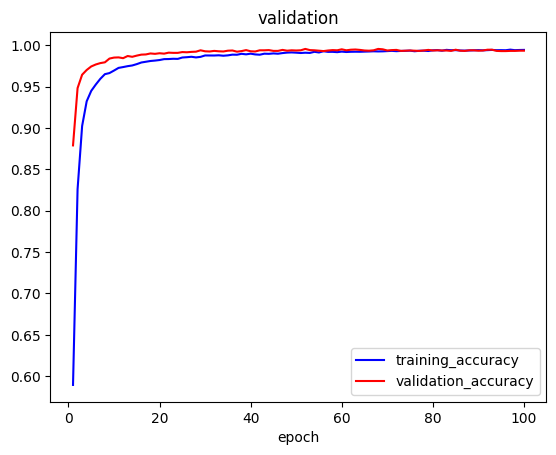

In [ ]:
# Drawing plots
epochs = [i for i in range(1, len(history.history['loss'])+1)]

plt.plot(epochs, history.history['loss'], color='blue', label="training_loss")
plt.plot(epochs, history.history['val_loss'], color='red', label="validation_loss")
plt.legend(loc='best')
plt.title('training')
plt.xlabel('epoch')
plt.savefig(TRAINING_PLOT_FILE, bbox_inches='tight')
plt.show()

plt.plot(epochs, history.history['accuracy'], color='blue', label="training_accuracy")
plt.plot(epochs, history.history['val_accuracy'], color='red',label="validation_accuracy")
plt.legend(loc='best')
plt.title('validation')
plt.xlabel('epoch')
plt.savefig(VALIDATION_PLOT_FILE, bbox_inches='tight')
plt.show()

#Download all files if needed

In [ ]:
#Downloading data if necessary
if GOOGLE_COLAB:
    files.download(MODEL_SUMMARY_FILE)
    files.download(MODEL_FILE)
    files.download(TRAINING_LOGS_FILE)
    files.download(VALIDATION_PLOT_FILE)
    files.download(TRAINING_PLOT_FILE)
    files.download(KAGGLE_SUBMISSION_FILE)